#Model 4 (ResNet50 + Siamese)

In [ ]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
import os
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow as tf
from tensorflow.keras.backend import max, mean, sqrt, square, sum

import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.models import Model

from tensorflow import keras
from keras.layers import LeakyReLU, Softmax
from keras.layers import Conv2D, Activation, Input,Dropout,Lambda,Flatten, Dense
from keras.layers import Dense, Flatten, Reshape, Activation
from keras.layers import BatchNormalization ,ZeroPadding2D

from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import one_hot, reshape


from tensorflow.keras.layers import Activation, Add, AvgPool2D, BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
from numpy import rint
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from numpy import expand_dims
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow import one_hot, reshape
from keras.layers import BatchNormalization
import cv2

# from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with tf.device('/device:GPU:0'):
  colab = True
  # database = 'bigsig260_224x224_siamese_preprocessed.h5'
  if colab:
      # from google.colab import drive
      # drive.mount('/content/gdrive')
      file = '/content/drive/MyDrive/bigsig260155x220x1_siamese_preprocessed.h5'
  else:
      file = os.path.join(os.getcwd(),'RoboticLab', database)
  print(file)
  with File(file, 'r') as hdf:
      S1 = np.array(hdf.get('S1'))
      S2 = np.array(hdf.get('S2'))
      Y = np.array(hdf.get('Y'))
  print(S1.shape)
  print(S2.shape)
  print(Y.shape)

/content/drive/MyDrive/bigsig260155x220x1_siamese_preprocessed.h5
(29880, 155, 220, 1)
(29880, 155, 220, 1)
(29880, 1)


In [ ]:
res_net = ResNet18(input_shape = (155, 220, 1),input_tensor = S1[1] ,weights='imagenet',classes = 2)

AttributeError: ignored

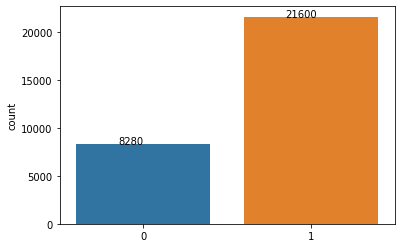

In [ ]:
ax = sns.countplot(x = Y.reshape(Y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(Y),y = Y.reshape(Y.shape[0]))
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.8043478260869565, 1: 0.6916666666666667}

In [ ]:
Y = Y/1.0

In [ ]:
S1.dtype

dtype('uint8')

In [ ]:
with tf.device('/device:GPU:0'):
  seed=randint(10)
  print('seed='+str(seed))
  indices = permutation(Y.shape[0])
  m = int(0.70 * Y.shape[0])
  n = int(0.15 * Y.shape[0])
  training_id, validation_id, test_id = indices[:m], indices[m: m + n], indices[m+n:]
  S1_train, S1_test, S1_validate = S1[training_id], S1[test_id], S1[validation_id]
  S2_train, S2_test, S2_validate = S2[training_id], S2[test_id], S2[validation_id]
  Y_train, Y_test, Y_validate = Y[training_id], Y[test_id], Y[validation_id]
  print(S1_train.shape)
  print(S2_train.shape)
  print(Y_train.shape)

  del S1,S2,Y

seed=4
(20916, 155, 220, 1)
(20916, 155, 220, 1)
(20916, 1)


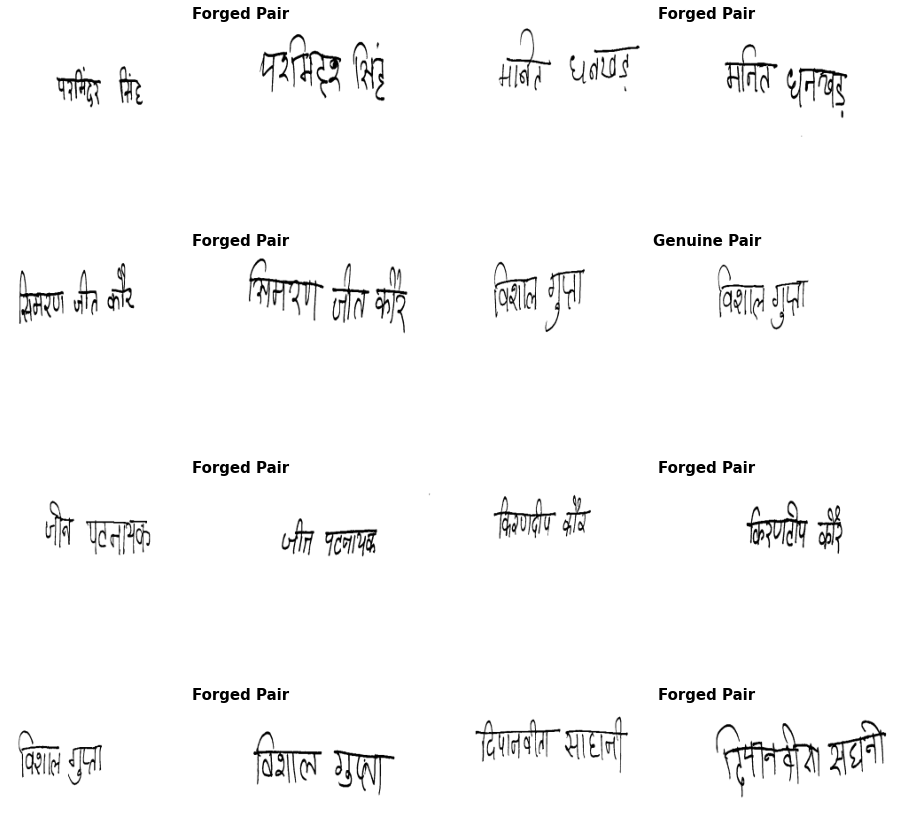

In [ ]:
fig = plt.figure(figsize = (16,16))
rows,cols = 4,4
i = 1
while(i in range(1,rows*cols)):
  random_idx = randint(0,len(S1_train))
  if(Y_train[random_idx] == 0):
    Label = "Genuine Pair"
  else:
    Label = "Forged Pair"
  img1 = S1_train[random_idx]
  img2 = S2_train[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img1.squeeze(),cmap = "gray");
  plt.axis(False);
  i += 1
  fig.add_subplot(rows,cols,i)
  plt.imshow(img2.squeeze(),cmap = "gray");
  plt.axis(False);
  plt.text(0.5, 0.5, Label, horizontalalignment='center',verticalalignment='center',fontsize=15,fontweight = 1000);
  i += 1

In [ ]:
# #One hot Encoding
# Y_train = one_hot(Y_train, depth=2)
# Y_train = reshape(Y_train, (-1, 2))

# Y_test = one_hot(Y_test, depth=2)
# Y_test = reshape(Y_test, (-1, 2))

# Y_validate = one_hot(Y_validate, depth=2)
# Y_validate = reshape(Y_validate, (-1, 2))

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform, activation='relu', seed=0):
    F1, F2, F3 = filters
    Y = X

    Y = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)

    Y = Add() ([Y, X])
    Y = Activation(activation = activation) (Y)

    return Y

In [ ]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform, activation='relu', seed=0):
    F1, F2, F3 = filters
    Y = X

    Y = Conv2D(filters=F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)

    X = Conv2D(filters=F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=seed)) (X)
    X = BatchNormalization() (X, training=training)

    Y = Add() ([Y, X])
    Y = Activation(activation = activation) (Y)

    return Y

In [ ]:
def  ResNet50(input_shape = (512, 512, 3), classes = 2, activation='relu', seed=0):
    Y = Input(input_shape)
    X = Y
    X = ZeroPadding2D(3)(X)

    X = Conv2D(filters=64, kernel_size = 7, strides = 2, kernel_initializer = glorot_uniform(seed=seed)) (X)
    X = BatchNormalization() (X)
    X = Activation(activation=activation) (X)
    X = MaxPool2D((3, 3), strides=(2, 2)) (X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, seed=seed)
    X = identity_block(X, 3, [64, 64, 256], seed=seed)
    X = identity_block(X, 3, [64, 64, 256], seed=seed)

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2, seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, seed=seed)
    X = identity_block(X, 3, [512, 512, 2048], seed=seed)
    X = identity_block(X, 3, [512, 512, 2048], seed=seed)

    X = AvgPool2D(pool_size=(2, 2))(X)
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', kernel_initializer = glorot_uniform(seed=seed))(X)

    model = Model(inputs = Y, outputs = X)
    return model

In [ ]:
input_shape=(155, 220,1)
input_shape

(155, 220, 1)

In [ ]:
plot_model(ResNet50(input_shape = input_shape), show_shapes=True)

In [ ]:
with tf.device('/device:GPU:0'):
  inputShape = S1_train.shape[1:]
  f = ResNet50(inputShape)

In [ ]:
def euclidean_distance(S):
  X = S['S1']
  Y = S['S2']
  return K.sqrt(K.maximum(K.sum(K.square(X - Y), axis=1, keepdims=True), K.epsilon()))

In [ ]:
input_a = Input(shape=inputShape, name = 'S1')
input_b = Input(shape=inputShape, name = 'S2')
encoded_s1 = f(input_a)
encoded_s2 = f(input_b)
distance = Lambda(euclidean_distance)({'S1': encoded_s1, 'S2': encoded_s2})
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs = [input_a, input_b], outputs = outputs)

In [ ]:
def constructive_loss(y_true, y_pred):
  margin = 1
  y_true = tf.cast(y_true, y_pred.dtype)
  squaredPreds = K.square(y_pred)
  squaredMargin = K.square(K.maximum(margin - y_pred, 0))
  loss = K.mean(y_true * squaredMargin + (1 - y_true) * squaredPreds)
  return loss

## **HYPER PARAMETER TUNING**

## **BATCH SIZE TUNING**

In [ ]:
# with tf.device('/device:GPU:0'):
#   for i in np.arange(0.0010,0.0101,0.0010):
#     adam = Adam(learning_rate = 0.001,epsilon = 1e-08)
#     model.compile(loss = constructive_loss, optimizer = adam, metrics=['BinaryAccuracy'])
#     print("For Learning Rate = {LR}".format(LR = i))


In [ ]:
with tf.device('/device:GPU:0'):
  adam = Adam(learning_rate = 0.001,epsilon = 1e-08)
  model.compile(loss = constructive_loss, optimizer = adam, metrics=['BinaryAccuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 8
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  8
2802/2802 [==============================] - 213s 72ms/step - loss: 0.0934 - binary_accuracy: 0.9104 - val_loss: 0.0813 - val_binary_accuracy: 0.9186


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 16
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  16
1401/1401 [==============================] - 160s 107ms/step - loss: 0.0904 - binary_accuracy: 0.9103 - val_loss: 0.0883 - val_binary_accuracy: 0.9116


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 32
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  32
701/701 [==============================] - 132s 172ms/step - loss: 0.0979 - binary_accuracy: 0.9093 - val_loss: 0.0795 - val_binary_accuracy: 0.9205


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 64
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  64
351/351 [==============================] - 120s 311ms/step - loss: 0.0908 - binary_accuracy: 0.9108 - val_loss: 0.0768 - val_binary_accuracy: 0.9232


In [ ]:
with tf.device('/device:GPU:0'):
  batch_Size = 128
  print("For batch Size : ",batch_Size)
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 1,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For batch Size :  128
176/176 [==============================] - 118s 605ms/step - loss: 0.0928 - binary_accuracy: 0.9084 - val_loss: 0.0779 - val_binary_accuracy: 0.9221


**THE BEST ACCURACY IS FOR BATCH SIZE = 64**

## **LEARNING RATE**

In [ ]:
batch_Size = 32

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-03
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  0.001
Epoch 1/5
654/654 [==============================] - 327s 463ms/step - loss: 0.2045 - binary_accuracy: 0.7242 - val_loss: 0.2017 - val_binary_accuracy: 0.7200
Epoch 2/5
654/654 [==============================] - 301s 460ms/step - loss: 0.2020 - binary_accuracy: 0.7248 - val_loss: 0.2018 - val_binary_accuracy: 0.7200
Epoch 3/5
654/654 [==============================] - 321s 491ms/step - loss: 0.2021 - binary_accuracy: 0.7248 - val_loss: 0.2016 - val_binary_accuracy: 0.7200
Epoch 4/5
654/654 [==============================] - 301s 460ms/step - loss: 0.2023 - binary_accuracy: 0.7248 - val_loss: 0.2017 - val_binary_accuracy: 0.7200
Epoch 5/5
654/654 [==============================] - 301s 460ms/step - loss: 0.2022 - binary_accuracy: 0.7248 - val_loss: 0.2016 - val_binary_accuracy: 0.7200


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-04
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  0.0001
Epoch 1/5
654/654 [==============================] - 36s 39ms/step - loss: 0.2232 - binary_accuracy: 0.7001 - val_loss: 0.2445 - val_binary_accuracy: 0.7129
Epoch 2/5
654/654 [==============================] - 25s 38ms/step - loss: 0.2047 - binary_accuracy: 0.7146 - val_loss: 0.2358 - val_binary_accuracy: 0.7140
Epoch 3/5
654/654 [==============================] - 25s 38ms/step - loss: 0.2008 - binary_accuracy: 0.7189 - val_loss: 0.2318 - val_binary_accuracy: 0.7115
Epoch 4/5
654/654 [==============================] - 24s 37ms/step - loss: 0.1992 - binary_accuracy: 0.7188 - val_loss: 0.2352 - val_binary_accuracy: 0.7146
Epoch 5/5
654/654 [==============================] - 24s 37ms/step - loss: 0.1935 - binary_accuracy: 0.7259 - val_loss: 0.2279 - val_binary_accuracy: 0.7149


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-05
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-05
Epoch 1/5
654/654 [==============================] - 33s 35ms/step - loss: 0.2488 - binary_accuracy: 0.7070 - val_loss: 0.2451 - val_binary_accuracy: 0.7135
Epoch 2/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1971 - binary_accuracy: 0.7212 - val_loss: 0.2483 - val_binary_accuracy: 0.7135
Epoch 3/5
654/654 [==============================] - 23s 35ms/step - loss: 0.1953 - binary_accuracy: 0.7240 - val_loss: 0.2338 - val_binary_accuracy: 0.7135
Epoch 4/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1947 - binary_accuracy: 0.7232 - val_loss: 0.2389 - val_binary_accuracy: 0.7124
Epoch 5/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1917 - binary_accuracy: 0.7255 - val_loss: 0.2385 - val_binary_accuracy: 0.7135


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-06
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy' ])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-06
Epoch 1/5
654/654 [==============================] - 26s 36ms/step - loss: 0.2219 - binary_accuracy: 0.6782 - val_loss: 0.2373 - val_binary_accuracy: 0.7160
Epoch 2/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1969 - binary_accuracy: 0.7241 - val_loss: 0.2315 - val_binary_accuracy: 0.7160
Epoch 3/5
654/654 [==============================] - 22s 34ms/step - loss: 0.1910 - binary_accuracy: 0.7257 - val_loss: 0.2267 - val_binary_accuracy: 0.7160
Epoch 4/5
654/654 [==============================] - 25s 39ms/step - loss: 0.1865 - binary_accuracy: 0.7283 - val_loss: 0.2198 - val_binary_accuracy: 0.7160
Epoch 5/5
202/654 [========>.....................] - ETA: 14s - loss: 0.1819 - binary_accuracy: 0.7333

KeyboardInterrupt: ignored

In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-07
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-07
Epoch 1/5
654/654 [==============================] - 32s 37ms/step - loss: 2.3212 - binary_accuracy: 0.2760 - val_loss: 0.2162 - val_binary_accuracy: 0.7115
Epoch 2/5
654/654 [==============================] - 23s 34ms/step - loss: 0.4720 - binary_accuracy: 0.3013 - val_loss: 0.2243 - val_binary_accuracy: 0.7135
Epoch 3/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2376 - binary_accuracy: 0.6079 - val_loss: 0.2404 - val_binary_accuracy: 0.7135
Epoch 4/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2098 - binary_accuracy: 0.7163 - val_loss: 0.2480 - val_binary_accuracy: 0.7135
Epoch 5/5
654/654 [==============================] - 22s 34ms/step - loss: 0.2044 - binary_accuracy: 0.7230 - val_loss: 0.2509 - val_binary_accuracy: 0.7135


In [ ]:
with tf.device('/device:GPU:0'):
  lr = 1e-08
  print("For learning Rate = ",lr)
  rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
  model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])
  model.fit(x = [S1_train, S2_train],y = Y_train,
                        validation_data = ([S1_validate,S2_validate],Y_validate),
                        epochs = 5,batch_size = batch_Size,class_weight = class_weight_dict,shuffle = True
                        )

For learning Rate =  1e-08
Epoch 1/5
654/654 [==============================] - 29s 42ms/step - loss: 0.1911 - binary_accuracy: 0.7238 - val_loss: 0.2165 - val_binary_accuracy: 0.7320
Epoch 2/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1907 - binary_accuracy: 0.7241 - val_loss: 0.2162 - val_binary_accuracy: 0.7320
Epoch 3/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1910 - binary_accuracy: 0.7238 - val_loss: 0.2154 - val_binary_accuracy: 0.7320
Epoch 4/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1914 - binary_accuracy: 0.7238 - val_loss: 0.2154 - val_binary_accuracy: 0.7320
Epoch 5/5
654/654 [==============================] - 25s 38ms/step - loss: 0.1908 - binary_accuracy: 0.7241 - val_loss: 0.2160 - val_binary_accuracy: 0.7320


## **FINAL TRAINING**

***BEST LEARNING RATE IS 1e-04***

In [ ]:
folder = '/content/drive/MyDrive/ResNet(1e-04)Hindi220x155Inversed'

In [ ]:
Batch_size = 32
lr = 1e-04
Epochs = 30

In [ ]:
with tf.device('/device:GPU:0'):
    rms = RMSprop(learning_rate = lr,epsilon = 1e-08,momentum = 0.9,rho = 0.9)
    model.compile(loss = constructive_loss, optimizer = rms, metrics=['BinaryAccuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=6, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(folder + '/Weights/resnet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit(x = [S1_train, S2_train],y = Y_train,
                  validation_data = ([S1_validate,S2_validate],Y_validate),
                  epochs = Epochs,
                  callbacks = callbacks,
                  batch_size = Batch_size,
                  class_weight = class_weight_dict
                  )

Epoch 1/30
654/654 [==============================] - ETA: 0s - loss: 0.2256 - binary_accuracy: 0.7226
Epoch 1: saving model to /content/drive/MyDrive/ResNet(1e-04)Hindi220x155Inversed/Weights/resnet-bhsig260-001.h5
654/654 [==============================] - 334s 484ms/step - loss: 0.2256 - binary_accuracy: 0.7226 - val_loss: 0.2081 - val_binary_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 2/30
654/654 [==============================] - ETA: 0s - loss: 0.2051 - binary_accuracy: 0.7237
Epoch 2: saving model to /content/drive/MyDrive/ResNet(1e-04)Hindi220x155Inversed/Weights/resnet-bhsig260-002.h5
654/654 [==============================] - 329s 503ms/step - loss: 0.2051 - binary_accuracy: 0.7237 - val_loss: 0.2014 - val_binary_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 3/30
654/654 [==============================] - ETA: 0s - loss: 0.2029 - binary_accuracy: 0.7237
Epoch 3: saving model to /content/drive/MyDrive/ResNet(1e-04)Hindi220x155Inversed/Weights/resnet-bhsig260-003.h5
654/654 [===========

In [ ]:
# Y_train.shape

In [ ]:
import pickle

In [ ]:
with open(folder  + '/trainHistoryDict', 'wb') as file_pi:
       pickle.dump(results, file_pi)
# model.save(folder + 'BestModel.h5')

NameError: ignored

In [ ]:
# import pickle
# history = pickle.load(open(folder + '/trainHistoryDict', "rb"))

In [ ]:
results.history['val_loss'].index(min(results.history['val_loss'])) + 1

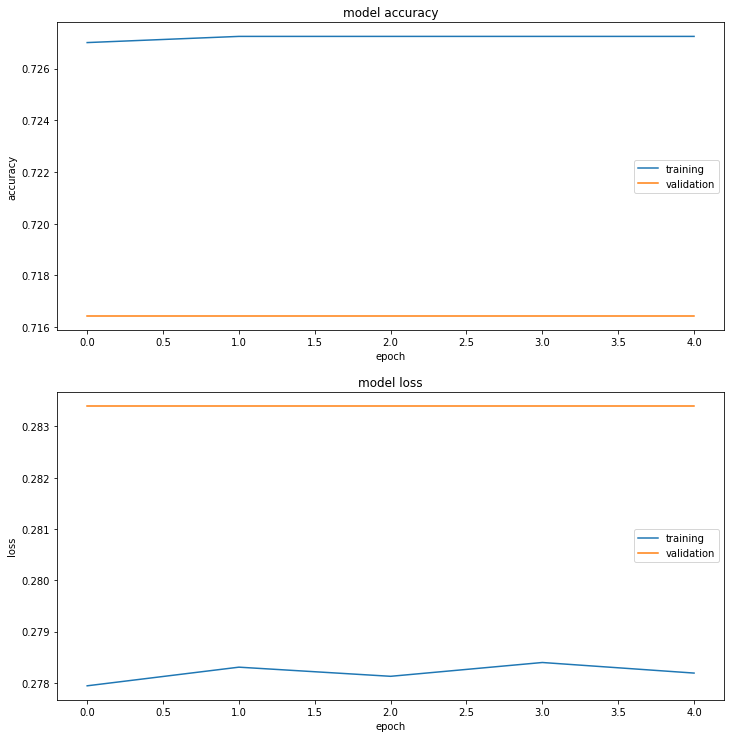

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(results.history['binary_accuracy'], results.history['val_binary_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)
plt.savefig(folder + "loss_accuracy.svg",dpi = 1200)

In [ ]:
y_pred_keras

<tf.Tensor: shape=(4482,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

141/141 [==============================] - 30s 211ms/step


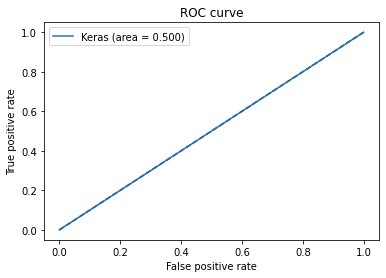

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
y_pred_keras = model.predict([S1_test, S2_test])
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(folder + "roc.svg",dpi = 1200)
plt.show()

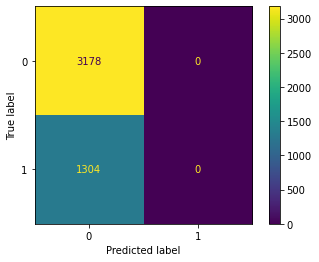

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test, tf.argmax(y_pred_keras,axis = 1))).plot()
plt.savefig(folder + "confusionmatrix.svg",dpi = 1200)
plt.show()

In [ ]:
y_pred_keras

array([[0.00031623],
       [0.00031623],
       [0.00031623],
       ...,
       [0.00031623],
       [0.00031623],
       [0.00031623]], dtype=float32)